### GITHUB:https://github.com/pytorch/hub
### 模型：https://pytorch.org/hub/research-models

In [4]:
pip install pillow


Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [1]:
import PIL
print(PIL.__version__)


10.3.0


In [5]:
# https://pytorch.org/hub/pytorch_vision_fcn_resnet101/

import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)
model.eval()


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\zyy/.cache\torch\hub\v0.10.0.zip
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\zyy/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [03:09<00:00, 747kB/s]    


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [7]:
len(torch.hub.list('pytorch/vision:v0.10.0'))

Using cache found in C:\Users\zyy/.cache\torch\hub\pytorch_vision_v0.10.0


41

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (N, 3, H, W), where N is the number of images, H and W are expected to be at least 224 pixels. 

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

The model returns an OrderedDict with two Tensors that are of the same height and width as the input Tensor, but with 21 classes. output['out'] contains the semantic masks, and output['aux'] contains the auxillary loss values per-pixel. In inference mode, output['aux'] is not useful. So, output['out'] is of shape (N, 21, H, W). More documentation can be found here.

In [8]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)


In [9]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

# unsqueeze adds a dimension of size one at the specified position, creating a mini-batch that the model expects.
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]

# gets the model's highest-confidence prediction by using `argmax(0)` to find the torch.Tensor index where the maximum value occurs.
output_predictions = output.argmax(0)

In [13]:
output.size()

torch.Size([21, 1026, 1282])

The output here is of shape (21, H, W), and at each location, there are unnormalized probabilities corresponding to the prediction of each class. 

To get the maximum prediction of each class, and then use it for a downstream task, you can do output_predictions = output.argmax(0).

Here’s a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

In [14]:
output_predictions.size()

torch.Size([1026, 1282])

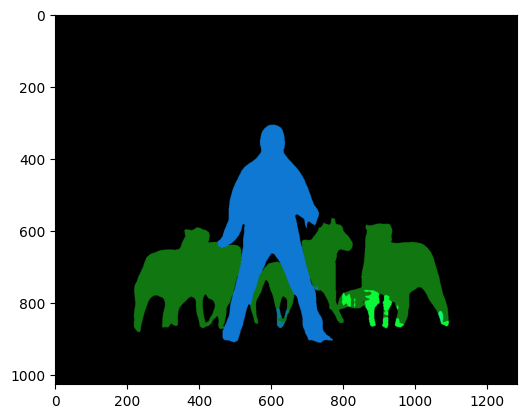

In [15]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

### Model Description

FCN-ResNet is constructed by a Fully-Convolutional Network model, using a ResNet-50 or a ResNet-101 backbone. The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.